# I want this network to learn a single moving average

In [13]:
import numpy as np
import torch
from torch import nn
from torch.nn import Conv2d, Flatten, LazyLinear, Linear, MaxPool2d, ReLU


In [642]:
class DeepQNet(nn.Module):
    def __init__(self):
        super(DeepQNet, self).__init__()

        self.layers = nn.ModuleList()
        # self.layers.append(Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 1)))
        # self.layers.append(ReLU())
        # self.layers.append(MaxPool2d(kernel_size=(3, 1), stride=(3, 1)))

        # self.layers.append(Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 1)))
        # self.layers.append(ReLU())
        # self.layers.append(MaxPool2d(kernel_size=(4, 1), stride=(2, 1)))
        #
        # self.layers.append(Conv2d(in_channels=1, out_channels=1, kernel_size=(8, 1)))
        # self.layers.append(ReLU())
        # self.layers.append(MaxPool2d(kernel_size=(4, 1), stride=(2, 1)))
        #
        # self.layers.append(Conv2d(in_channels=1, out_channels=1, kernel_size=(16, 1)))
        # self.layers.append(ReLU())
        # self.layers.append(MaxPool2d(kernel_size=(8, 1), stride=(2, 1)))
        #
        # self.layers.append(Flatten())
        # self.layers.append(Linear(in_features=1400, out_features=500))
        # self.layers.append(ReLU())
        # self.layers.append(LazyLinear(out_features=100))
        # self.layers.append(ReLU())
        #
        self.layers.append(Linear(in_features=1400, out_features=1000))
        self.layers.append(ReLU())
        # self.layers.append(LazyLinear(out_features=1000))
        # self.layers.append(ReLU())
        self.layers.append(LazyLinear(out_features=1))

        # self.layers.append(Linear(in_features=1400, out_features=500))
        # self.layers.append(ReLU())
        # self.layers.append(LazyLinear(out_features=250))
        # self.layers.append(ReLU())
        # self.layers.append(LazyLinear(out_features=250))
        # self.layers.append(ReLU())
        # self.layers.append(LazyLinear(out_features=1))

    def forward(self, x):
        assert list(x.size()[1:]) == [200, 7]
        # x = x.flatten()
        x = x.reshape(-1, 1400)
        for idx, layer in enumerate(self.layers):
            # print(f'On layer {layer} with input size {x.size()}')
            x = layer(x)
        return x

In [643]:
def moving_avg_diff(X):
    moving_avg_200 = np.mean(X[:, 0])
    moving_avg_50 = np.mean(X[0:-50, 0])
    return moving_avg_200 - moving_avg_50

In [645]:
import tqdm

model = DeepQNet()
# optimizer = torch.optim.Adam(params=model.parameters())
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

Xs = np.random.random(size=(2000, 200, 7)) * 10 + np.random.randint(-5, 5)
Ys = np.array([moving_avg_diff(x) for x in Xs])
losses = []
display = tqdm.trange(450)
for train_iter in display:
    X = Xs[train_iter % len(Xs)]
    Y = [moving_avg_diff(X)]

    # pred = model(torch.as_tensor([X], dtype=torch.float32))
    pred = model(torch.as_tensor([Xs[0]], dtype=torch.float32))
    loss = torch.nn.MSELoss()(pred, torch.as_tensor([Ys[0].reshape(-1, 1)], dtype=torch.float32))
    loss.backward()
    losses.append(loss.item())

    optimizer.step()
    model.zero_grad()

    display.set_postfix_str(f'Loss: {loss.item():.5}')

  0%|          | 0/450 [00:00<?, ?it/s]


AttributeError: 'tuple' object has no attribute 'shape'

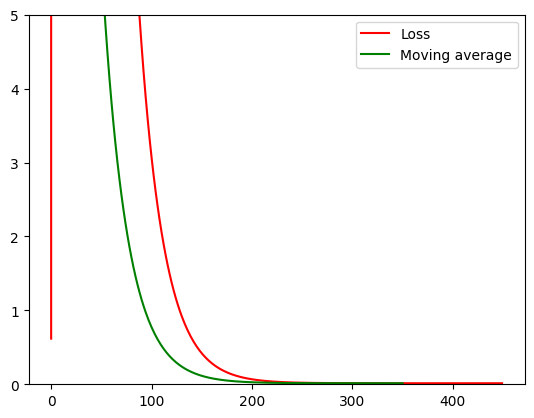

In [641]:
from matplotlib import pyplot as plt
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

avgs = moving_average(losses, n=100)
plt.plot(range(len(losses)), losses, c='r', label='Loss')
plt.plot(range(len(avgs)), avgs, c='g', label='Moving average')
plt.ylim((0, 5))
plt.legend()

In [633]:
x = Xs[1299]
# x = np.random.random(size=(200, 7)) * 10 + np.random.randint(-5, 5)

# pred = model(torch.as_tensor([x.flatten()], dtype=torch.float32))
pred = model(torch.as_tensor([x], dtype=torch.float32))
gt = moving_avg_diff(x)
print(f'Predicted: {pred.item()}')
print(f'True: {gt}')

Predicted: 0.026406148448586464
True: 0.08845803864018986


In [486]:
import tqdm

model = DeepQNet()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

n_accum = 1

losses = []
display = tqdm.trange(2000)
for train_iter in display:
    X = np.random.random(size=(200, 7)) * 10 + np.random.randint(-5, 5)


    pred = model(torch.as_tensor([X.flatten()], dtype=torch.float32))
    Y = [moving_avg_diff(X)]
    loss = torch.nn.MSELoss()(pred, torch.as_tensor([Y], dtype=torch.float32))
    # loss = torch.nn.MSELoss()(pred, torch.as_tensor([Y, 0, 0, 0, 0], dtype=torch.float32))
    loss /= n_accum
    loss.backward()
    losses.append(loss.item())

    if train_iter % n_accum == 0:
        optimizer.step()
        model.zero_grad()

    display.set_postfix_str(f'Loss: {loss.item():.5}')
    # break


/Users/marc/opt/anaconda3/envs/rl/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
100%|██████████| 2000/2000 [00:16<00:00, 121.09it/s, Loss: 0.005845]  
